# Fill in outs 
## June

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os


from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


## We don't know now many outs there are at any point!

In [ ]:
bf_1903_30 = Baseball_Field("1903_30_TeamNB_TeamA1")

In [ ]:
first_two_innings = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"].isin([1, 2])), :].copy()

first_two_innings["prev_outs"] = np.nan
first_two_innings["this_play_outs"] = np.nan


first_two_innings["n_br"] = first_two_innings[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


# the number of outs but be the same as before
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"


# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = first_two_innings.loc[first_two_innings["top_bottom_inning"].shift() != first_two_innings["top_bottom_inning"]].index

first_two_innings.loc[switiching_sides_indices, "prev_outs"] = 0



In [ ]:
# the number of outs but be the same as before
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"
hr_play_per_games = bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"].values


e = bf_1903_30.game_obj.game_events_df
flyouts_that_end_play = e.loc[(e["event"] == "ball acquired") & (e["player_position"].isin([7, 8, 9])) & (e["next_event"] == "end of play"), "play_per_game"]


In [ ]:
# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = first_two_innings.loc[first_two_innings["top_bottom_inning"].shift() != first_two_innings["top_bottom_inning"]].index


first_two_innings.loc[switiching_sides_indices, "prev_outs"] = 0


In [ ]:
first_two_innings.loc[12:30, :]

## Lean full into the Sudoku solver strategy


At a high level, I think I need:
- a recursive function that returns true or false
    - a for loop from 0, 2 (inclusive)
- a thing that finds an empty cell
- an "is_valid_outs" function where I enumerate all of my rules


### I think I want to keep the half inning df, but pass around the sequences!

In [ ]:
def get_play_id_and_ppg_for_event(game_obj, event, **kwargs):
    """
    takes in a game_events_df
    
    event is "home run", etc
    
    """
    event_indices = game_obj.game_events_df["event"] == event
    
    if len(kwargs) != 0:
        
        for k,v in kwargs.items():
                        
            if type(v) is list:                
                event_indices = (event_indices) & (game_obj.game_events_df[k].isin(v))
                
            else:
                event_indices = (event_indices) & (game_obj.game_events_df[k] == v)
            
    return game_obj.game_events_df.loc[event_indices, ["play_id", "play_per_game"]].drop_duplicates()
    
    

# get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "home run")


get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "ball acquired", player_position=[7, 8, 9], next_event="end of play")



In [ ]:
def solve_outs_sequence_seq(game_obj, half_inning_df, seq):
    
    empty_cell_index = find_empty_cell_seq(seq)
    
    if empty_cell_index is None:
        # you have found a valid solution and this is what makes your thing return
        return True
    
    
    for this_play_outs in range(3):
        
        if is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
            seq[empty_cell_index, 1] = this_play_outs
            
            temp_sum = 0 if empty_cell_index == 0 else sum(seq[empty_cell_index - 1, :])
            
            seq[empty_cell_index, 0] = temp_sum
            
            pass
            
            
            if solve_outs_sequence_seq(game_obj, half_inning_df, seq):
                # you did it!
                return True
        
            seq[empty_cell_index, 0] = np.nan
            seq[empty_cell_index, 1] = np.nan
            
    return False


def find_empty_cell_seq(seq):
        
    index = None
    
    # this play outs is in the second column!
    
    for i, val in enumerate(seq[:, 1]):
        if np.isnan(val):
            return i
    
    return index


def is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
    
    all_batting_team = ["batter", "first_baserunner", "second_baserunner", "third_baserunner"]
    all_br = ["first_baserunner", "second_baserunner", "third_baserunner"]
    
    seq_len = seq.shape[0]
    
    # debugging
    
    this_row = half_inning_df.iloc[empty_cell_index]
    
    old_set_batting_team = set()
    prev_total_outs = 0
    
    if empty_cell_index != 0:
        # you need to set and check all of the things that look at the prev row 
        old_set_batting_team = set(half_inning_df.iloc[empty_cell_index - 1][all_batting_team])
        prev_total_outs = sum(seq[empty_cell_index - 1, :])
          
    next_batter = None
    next_set_batting_team = set()
    next_set_br = set()
    next_second_br = None
    next_third_br = None
    

    hr_play_per_games = get_play_id_and_ppg_for_event(game_obj, "home run")["play_per_game"].values

    flyouts_that_end_play = get_play_id_and_ppg_for_event(game_obj,
                                                          "ball acquired", 
                                                          player_position=[7, 8, 9],
                                                          next_event="end of play")["play_per_game"].values

    

    if empty_cell_index < seq_len - 1:
        next_batter = half_inning_df.iloc[empty_cell_index + 1]["batter"]
        next_set_batting_team = set(half_inning_df.iloc[empty_cell_index + 1][all_batting_team])
        next_set_br = set(half_inning_df.iloc[empty_cell_index + 1][all_br])
        
        next_second_br = half_inning_df.iloc[empty_cell_index + 1]["second_baserunner"]
        next_third_br = half_inning_df.iloc[empty_cell_index + 1]["third_baserunner"]
    
    this_batter = half_inning_df.iloc[empty_cell_index]["batter"]
    this_set_br = set(half_inning_df.iloc[empty_cell_index][all_br])
    this_first_br = half_inning_df.iloc[empty_cell_index]["first_baserunner"]
    this_second_br = half_inning_df.iloc[empty_cell_index]["second_baserunner"]
    this_third_br = half_inning_df.iloc[empty_cell_index]["third_baserunner"]
    
    
    
    same_batter_next_play = this_batter == next_batter
    
    # Outs has to be the same or more as all previous indices in the sequence
    this_set_batting_team = set(half_inning_df.iloc[empty_cell_index][all_batting_team])
        
    
    does_this_make_3 = prev_total_outs + this_play_outs
    
    this_play_per_game = half_inning_df.iloc[empty_cell_index]["play_per_game"]
    
    # hr_play_per_games = bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"].values
    
    ## end debugging
    
    pass
    
    # Assuming consecutive indices!

    
    # TODO: 
    # It can't be an out if the batter is on base next play and a runner scores
    


    if this_play_outs != 0 and this_play_per_game \
        in hr_play_per_games:
        # Outs can't go up on a home run
        return False

    if this_play_outs == 0 and this_batter not in next_set_br \
        and this_batter != next_batter and this_play_per_game not in hr_play_per_games:
        # if the batter is not on the bases when there is a new batter and it wasn't a HR then the batter got out:
    
        return False
    
    
    if this_play_outs > 1 and this_play_per_game in flyouts_that_end_play:
    # if the last thing that happens is a ball being acquired by an outfield, then there can't be more than 1 out on the play
    # this will fail if the outfielders get into a run down and tag someone out for a double play, but that seems super rare
        return False
    
    
    if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_first_br not in next_set_br and this_first_br != 0 and \
            ((this_second_br in next_set_br and this_second_br != 0) or (this_third_br in next_set_br and this_third_br != 0)):
        # Outs must go up if there is a runner this isn't on the bases on the next play, and there are were runners ahead of them on this play
        
        # Fielders choice out at second
        
        return False
     
        
    """
     if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_second_br not in next_set_br  and this_third_br in next_set_br and this_third_br != "0"):
        
        # Fielders choice out at third
        
        return False
    """
         
    # TODO: Fielders choice out at home??
        
    
        
    if this_play_outs != 1 and set([br for br in this_set_br if br != 0 ]) == set([br for br in next_set_br if br != 0 ]) \
        and this_batter != next_batter:
        # TODO:
        # It must be 1 out if there are non zero BRs that stay the same, and there is a new batter -- this is a strikeout
        # Assumption this goes wrong for mid at bat PH, but that might be rare -- ignore that
        
        return False
    
    
    if this_play_outs != 0 and this_set_batting_team == next_set_batting_team:
    # Outs can't go up is there is the same batter and baserunners
        return False
    
    
    if this_play_outs > (1 + half_inning_df.iloc[empty_cell_index]["n_br"]):
        # Outs can't go up by more than the number of baserunners + 1
        return False
    
    if this_play_outs != 0 \
        and next_set_br == this_set_batting_team:
        # and half_inning_df.iloc[empty_cell_index - 1]["batter"] != 0\ # not sure about this part
        
            # Outs can't go up if the batter becomes the baserunner on the next play 
            # and the previous set of baserunners is still there

            return False
    
    
    if this_play_outs != 0 and len(this_set_batting_team) == 2 and same_batter_next_play:
        # Outs can't go up if there are no baserunners and the batter is the same in the next play
        # len(this_set_batting_team) == 2 is because the set will be batter_num and 0
    
        return False
        
    
    
    if ((seq_len - 1) == (empty_cell_index)) \
        and (does_this_make_3 != 3):
        # if we are on the last index, then this_play_outs and prev_outs must sum to three
        
        return False

    
    
    
    return True



    
    

#### Test case on an obviously 1-2-3 inning

In [ ]:
first_half = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = first_half[["prev_outs", "this_play_outs"]].copy().values

solve_outs_sequence_seq(bf_1903_30.game_obj, first_half, outs_seq)

print(outs_seq)

In [ ]:
first_half.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq

In [ ]:
first_half

### Bottom of the first
#### this one seems harder, because there are baserunners, etc

- if something is wrong on this, I think the plan will be to check things like throws and balls acquired, etc


In [ ]:
bottom_first = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_first[["prev_outs", "this_play_outs"]].copy().values

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_first, outs_seq)

print(outs_seq)


In [ ]:
bottom_first.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_first


##### Description of bottom of the first

Brainstorming on how where this is wrong, and what could be done to make it work better
- I think "baserunner scores" could be something?

A description of what is going on rn:

- 20 is an advancement on a passed ball or wild pitch
- 22 is a single that moves the runner to single I think -- its actually a fielding error lol
- 27 is another advancement on a passed ball or wild pitch
- 29 is this an RBI ground out that gets called safe?

- 34 is a single to right, with the runner on third scoring
- 39 is a walk or right?
- 43 is another walk? it was wayyyy outside lol
- 46 should have been a strikeout I think? --- COME UP WITH A STRIKEOUT RULE? Maybe if there is a new batter, and all the br stay the same -- this goes wrong for mid at bat PH, but that might be rare -- 
- 51 is a walk that gets marked a strikeout -- FIX HERE -- It can't be an out if that batter it on base next play
- 56 is a flyout to center field, -- FIX HERE -- it is only one out! 

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(56)

bf_1903_30.plot_all_components(play_id=play_id)

bf_1903_30.fig
# bf_1903_30.create_gif(play_id=play_id, tag="--is this a dp")

### Top of the second

In [ ]:
top_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = top_second[["prev_outs", "this_play_outs"]].copy().values

solve_outs_sequence_seq(bf_1903_30.game_obj, top_second, outs_seq)

print(outs_seq)


In [ ]:
top_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_second

##### Top of second description

A description of what is going on rn:

- 62 was a 4-3 put out
- 65 is a 6-3 put out
- 69 is a dropped third strike lol
- 75 is 6 unassisted

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(75)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--6_unassisted")

### Bottom of the second

In [ ]:
bottom_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_second[["prev_outs", "this_play_outs"]].copy().values

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_second, outs_seq)

print(outs_seq)


In [ ]:
bottom_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_second

##### Bottom of second description

A description of what is going on rn:

- 76 is a HBP lol that it counts as a ball deflection
- 78 is a double to left field
- 79 is a triple off the right center wall
- 83 is a walk
- 85 is a sac fly to center
- 87 is a 1-3 sacrifice?
- 90 is a lazy fly to left



In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(90)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")

### Top of 3

In [ ]:
top_three = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 3) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_three["prev_outs"] = np.nan
top_three["this_play_outs"] = np.nan

top_three["n_br"] = top_three[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_three[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_three, outs_seq)

print(outs_seq)

In [ ]:
top_three.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_three

#### Where should there be outs:
- 94 must be an out (strikeout)
- what happened on 95? This is a throwing error -- there should not be an out
- 97 (we don't know?) because it isn't there (but one out?)
- 108 is a play at the plate I think no outs
- 109 is a 5-3 put out

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(108)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 3

In [ ]:
bottom_three = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 3) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_three["prev_outs"] = np.nan
bottom_three["this_play_outs"] = np.nan

bottom_three["n_br"] = bottom_three[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_three[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_three, outs_seq)

print(outs_seq)

In [ ]:
bottom_three.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_three

This is a 1-2-3 inning

### Top 4

In [ ]:
top_four = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 4) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_four["prev_outs"] = np.nan
top_four["this_play_outs"] = np.nan

top_four["n_br"] = top_four[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_four[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_four, outs_seq)

print(outs_seq)

In [ ]:
top_four.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_four

### Bottom 4

In [ ]:
bottom_four = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 4) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_four["prev_outs"] = np.nan
bottom_four["this_play_outs"] = np.nan

bottom_four["n_br"] = bottom_four[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_four[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_four, outs_seq)

print(outs_seq)

In [ ]:
bottom_four.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_four

### Top 5

In [ ]:
top_five = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 5) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_five["prev_outs"] = np.nan
top_five["this_play_outs"] = np.nan

top_five["n_br"] = top_five[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_five[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_five, outs_seq)

print(outs_seq)

In [ ]:
top_five.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_five

Another 1-2-3

### Bottom 5

In [ ]:
bottom_five = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 5) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_five["prev_outs"] = np.nan
bottom_five["this_play_outs"] = np.nan

bottom_five["n_br"] = bottom_five[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_five[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_five, outs_seq)

print(outs_seq)

In [ ]:
bottom_five.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_five

#### Where should there be outs:

- 154 could be an out if its a play at the plate -- I think this is not an out
- 159 is a strikeout?
- 160 should have been a fielder's choice!
- 165 is a 6-4 put out


In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(165)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 6

In [ ]:
top_six = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 6) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_six["prev_outs"] = np.nan
top_six["this_play_outs"] = np.nan

top_six["n_br"] = top_six[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_six[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_six, outs_seq)

print(outs_seq)

In [ ]:
top_six.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_six

#### Where should there be outs:

- 171 is a popup
- 176 is proabably a wild pitch and a score -- lol
- 178 is a RBI sacrifice of some kind (6-3 RBI groundout)
- 182 is a strikeout


In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(182)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom of 6

In [ ]:
bottom_six = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 6) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_six["prev_outs"] = np.nan
bottom_six["this_play_outs"] = np.nan

bottom_six["n_br"] = bottom_six[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_six[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_six, outs_seq)

print(outs_seq)

In [ ]:
bottom_six.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_six

#### Where should there be outs:


- 187 is a steal?

- TODO: Bring this one up!!! 
    - 198 looks just like a pitch catch? but the third br disappears?
    
- 200 is a strikeout
- 202 is just a flyout -- maybe make a new rule for this one? (e.g. fly ball rule!)



In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(198)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(199)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

### Top 7

In [ ]:
top_seven = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 7) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_seven["prev_outs"] = np.nan
top_seven["this_play_outs"] = np.nan

top_seven["n_br"] = top_seven[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_seven[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_seven, outs_seq)

print(outs_seq)

In [ ]:
top_seven.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_seven

#### This is a 1-2-3 inning

### Bottom 7

In [ ]:
bottom_seven = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 7) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_seven["prev_outs"] = np.nan
bottom_seven["this_play_outs"] = np.nan

bottom_seven["n_br"] = bottom_seven[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_seven[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_seven, outs_seq)

print(outs_seq)

In [ ]:
bottom_seven.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_seven

#### This is a 1-2-3 inning

### Top of 8 is not working?

In [ ]:
top_eight = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 8) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_eight["prev_outs"] = np.nan
top_eight["this_play_outs"] = np.nan

top_eight["n_br"] = top_eight[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_eight[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_eight, outs_seq)

print(outs_seq)

In [ ]:
top_eight.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_eight

#### Where should there be outs:

- 234 is 4-3, runner advances
- 236 should be HR
- 249 is a strikeout
- 256 must be another strikeout



In [ ]:

bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(256)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Bottom 8

In [ ]:
bottom_eight = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 8) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Bottom") , :].copy()

bottom_eight["prev_outs"] = np.nan
bottom_eight["this_play_outs"] = np.nan

bottom_eight["n_br"] = bottom_eight[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = bottom_eight[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, bottom_eight, outs_seq)

print(outs_seq)

In [ ]:
bottom_eight.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_eight

#### A 1-2-3 inning

### Top 9

In [ ]:
top_nine = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"] == 9) & (bf_1903_30.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_nine["prev_outs"] = np.nan
top_nine["this_play_outs"] = np.nan

top_nine["n_br"] = top_nine[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_nine[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1903_30.game_obj, top_nine, outs_seq)

print(outs_seq)

In [ ]:
top_nine.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_nine

#### A 1-2-3 inning

## Turn this into a function, then integrate with Game

In [ ]:
full_game = bf_1903_30.game_obj.game_info_df.copy()

full_game["prev_outs"] = np.nan
full_game["this_play_outs"] = np.nan

full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

# TODO: refactor these into the function

# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

full_game.loc[switiching_sides_indices, "prev_outs"] = 0


In [ ]:

# make an array to store all of these
running_outs_seq = np.full((full_game.shape[0], 2), -99)

running_index = 0

for inning in range(1, 10):
    print(inning)
    
    for which_half in ["Top", "Bottom"]:
        print(which_half)
        
        this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]
        
        if this_half.shape[0] == 0:
            print("no data for the {} of {}".format(which_half, inning))
            
            # TODO: this means that the home team def won -- maybe track this
            continue
            
        outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
        print(outs_seq.shape)
            
        solve_outs_sequence_seq(bf_1903_30.game_obj, this_half, outs_seq)

        # the total number of outs made in a half inning must be 3
        assert sum(outs_seq[:, 1]) == 3
        
        # fill in this sequence into the array
        running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq   
        running_index += outs_seq.shape[0]


# assign the array back to those cols in the df
full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


In [ ]:
full_game.tail()

## Gut Checks



In [ ]:
# there should never be more than 3 outs in either column
full_game[["prev_outs", "this_play_outs"]].describe()

### Are all of the things that have two outs obvious double plays?

In [ ]:
full_game.loc[full_game["this_play_outs"] == 2, :]

### OTHER CHECKS HERE?





## Try again for a different game: 

In [ ]:
bf_1900_01 = Baseball_Field("1900_01_TeamKJ_TeamB")


In [ ]:
full_game = bf_1900_01.game_obj.game_info_df.copy()

full_game["prev_outs"] = np.nan
full_game["this_play_outs"] = np.nan


full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

full_game.loc[switiching_sides_indices, "prev_outs"] = 0

In [ ]:
bf_1900_01.game_obj.game_events_df.loc[bf_1900_01.game_obj.game_events_df["event"] == "home run"] 

In [ ]:
## DOUBLE CHECK THE INDICES HERE! 


# make an array to store all of these
running_outs_seq = np.full((full_game.shape[0], 2), -99)
running_index = 0

for inning in range(1, 3):
    print(inning)
    
    for which_half in ["Top", "Bottom"]:
        print(which_half)
        
        this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]
        
        
        if this_half.shape[0] == 0:
            print("no data for the {} of {}".format(which_half, inning))

            # TODO: this means that the home team def won in tghe inning is 9 -- maybe track this
            running_index += outs_seq.shape[0]
            continue
            
        outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
        print(outs_seq.shape)
            
        solve_outs_sequence_seq(bf_1900_01.game_obj, this_half, outs_seq)

        try: 
            assert sum(outs_seq[:, 1]) == 3

        except:
            print("Assertion Error: for the {} of {}".format(which_half, inning))
        
        # fill in this sequence into the array
        running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq
        
        running_index += outs_seq.shape[0]


# assign the array back to those cols in the df
full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


In [ ]:
full_game.head(30)

#### Weird missing baserunners in this game 1900_01_TeamKJ_TeamB
- 14, 15, 16 are missing the lead baserunner in game info
- I think there is something weird with the data here! the last play of the top half of the second is a HR
    - its play 52

- This game is all messed up! Idk that I want to deal with this tbh 
- I think just skip these half innings!


In [ ]:
top_two = bf_1900_01.game_obj.game_info_df.loc[(bf_1900_01.game_obj.game_info_df["inning"] == 2) & (bf_1900_01.game_obj.game_info_df["top_bottom_inning"] == "Top") , :].copy()

top_two["prev_outs"] = np.nan
top_two["this_play_outs"] = np.nan

top_two["n_br"] = top_two[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

outs_seq = top_two[["prev_outs", "this_play_outs"]].copy().values
outs_seq[0, 0] = 0

solve_outs_sequence_seq(bf_1900_01.game_obj, top_two, outs_seq)

print(outs_seq)


In [ ]:
top_two.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_two

In [ ]:
bf_1900_01.clear_plot()

play_id = bf_1900_01.game_obj.get_pid_from_ppg(26)

bf_1900_01.plot_all_components(play_id=play_id)
bf_1900_01.fig

# bf_1900_01.create_gif(play_id=play_id, tag="--7-6-5-1")


## Try a new game! 1903_13_TeamNG_TeamA3

In [ ]:
bf_1903_13 = Baseball_Field("1903_13_TeamNG_TeamA3")

In [ ]:
full_game = bf_1903_13.game_obj.game_info_df.copy()

full_game["prev_outs"] = np.nan
full_game["this_play_outs"] = np.nan


full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

full_game.loc[switiching_sides_indices, "prev_outs"] = 0

In [ ]:
## DOUBLE CHECK THE INDICES HERE! 


# make an array to store all of these
running_outs_seq = np.full((full_game.shape[0], 2), -99)
running_index = 0

for inning in range(1, 10):
    print(inning)
    
    for which_half in ["Top", "Bottom"]:
        print(which_half)
        
        this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]
        
        if this_half.shape[0] == 0:
            print("no data for the {} of {}".format(which_half, inning))

            # TODO: this means that the home team def won in tghe inning is 9 -- maybe track this
            running_index += outs_seq.shape[0]
            continue
            
        outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
        print(outs_seq.shape)
            
        solve_outs_sequence_seq(bf_1903_13.game_obj, this_half, outs_seq)

        try: 
            assert sum(outs_seq[:, 1]) == 3

        except:
            print("Assertion Error: for the {} of {}".format(which_half, inning))
            
        
        if np.isnan(outs_seq).all():
            # this means something went wrong, fill -99 so it is obvious
            outs_seq = np.full(outs_seq.shape, -99)
        
        
        # fill in this sequence into the array
        running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq
        
        running_index += outs_seq.shape[0]


# assign the array back to those cols in the df
full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


In [ ]:
full_game.head(20)

In [ ]:
full_game.loc[full_game["this_play_outs"] >= 1, :]

In [ ]:

bf_1903_13.clear_plot()

play_id = bf_1903_13.game_obj.get_pid_from_ppg(255)

bf_1903_13.plot_all_components(play_id=play_id)
bf_1903_13.fig


# bf_1903_13.create_gif(play_id=play_id, tag="--6-4-3_DP")


#### I think the whole game for bf_1903_13 works!

## Turn into a function

In [ ]:
def impute_outs(game_obj, verbose = True):
    
    which_innings_are_valid = {}
    
    full_game = game_obj.game_info_df.copy()

    full_game["prev_outs"] = np.nan
    full_game["this_play_outs"] = np.nan


    full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)


    # you know for certain that there are no outs when it is the first batter in the half inning
    switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

    full_game.loc[switiching_sides_indices, "prev_outs"] = 0
    

    # make an array to store all of these
    running_outs_seq = np.full((full_game.shape[0], 2), -99)
    running_index = 0

    for inning in range(1, 10):
        if verbose:
            print(inning)
        for which_half in ["Top", "Bottom"]:
            
            if verbose:
                print(which_half)
            
            which_innings_are_valid[str(inning) + "_" + which_half] = False

            this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]

            if this_half.shape[0] == 0:
                if verbose:
                    print("no data for the {} of {}".format(which_half, inning))

                # TODO: this means that the home team def won in tghe inning is 9 -- maybe track this
                running_index += outs_seq.shape[0]
                continue

            outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
            
            if verbose:
                print(outs_seq.shape)

            solve_outs_sequence_seq(game_obj, this_half, outs_seq)

            try: 
                assert sum(outs_seq[:, 1]) == 3

            except:
                if verbose:

                    print("Assertion Error: for the {} of {}".format(which_half, inning))


            # this won't work if there is literally one play?
            if np.isnan(outs_seq).all():
                # this means something went wrong, fill -99 so it is obvious
                outs_seq = np.full(outs_seq.shape, -99)


            # fill in this sequence into the array
            running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq

            running_index += outs_seq.shape[0]
            which_innings_are_valid[str(inning) + "_" + which_half] = True


    # assign the array back to those cols in the df
    full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq
    
    
    return full_game, which_innings_are_valid

    
    

## Spot check: 1903_17_TeamNI_TeamA3

In [ ]:
bf_1903_17 = Baseball_Field("1903_17_TeamNI_TeamA3")


In [ ]:
new_df, valid_innings = impute_outs(bf_1903_17.game_obj, verbose=True)

In [ ]:
this_half_df = new_df.loc[(new_df["inning"] == 7) & (new_df["top_bottom_inning"] == "Top"), :]
this_half_df

In [ ]:
get_play_id_and_ppg_for_event(bf_1903_17.game_obj, "home run")

#### Weird missing baserunners in this game 1903_17_TeamNI_TeamA3
- there are two play_per_game 3s here (I wonder if I just remove, if that goes away?)
- Bottom of 1 is missing some plays for sure!
- Top of 4 is literally 1 play, which messes up the -99 assignment
- there is also some duplicate play_per_games here 187




In [ ]:
new_df.loc[new_df["this_play_outs"] > 0, :]

In [ ]:
which_play = new_df.loc[new_df["this_play_outs"] > 0, "play_per_game"].values[29]
print(which_play)

In [ ]:

bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(which_play)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig


# bf_1903_17.create_gif(play_id=play_id, tag="--2-3 bunt")


#### A curiousity for later -- throws to first where the batter is safe?

In [ ]:
g_1903_17_events = bf_1903_17.game_obj.game_events_df.copy()

g_1903_17_events.loc[(g_1903_17_events["event"] == "ball acquired") & (g_1903_17_events["player_position"] == 3) &\
                     g_1903_17_events["play_per_game"].isin(new_df.loc[new_df["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

In [ ]:
bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(164)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig

## Spot check: 1902_24_TeamMA_TeamA1

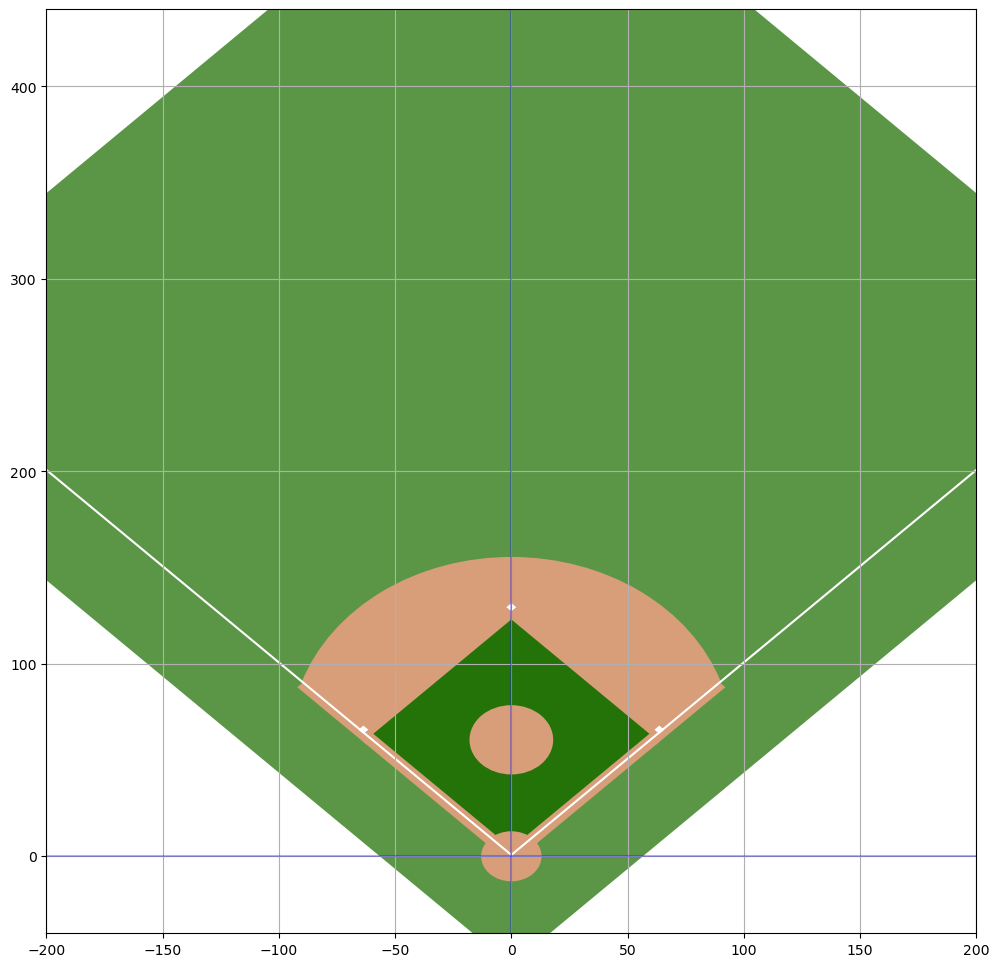

In [3]:
bf_1902_24 = Baseball_Field("1902_24_TeamMA_TeamA1")

In [4]:
game_info_1902_24 = bf_1902_24.game_obj.game_info_df.copy()

In [17]:
game_info_1902_24.loc[(game_info_1902_24["this_play_outs"] > 0) & (game_info_1902_24["trust_this_half"] == 1), :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
4,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,2.0,5,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,6057,7038,0,0,1,0,1,1,1,1,0,0,1,1,1
9,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,3.0,10,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,3041,0,7038,0,1,1,1,1,1,0,1,0,1,1,1
13,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,4.0,14,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,7415,0,7038,0,1,2,1,1,1,0,1,0,1,1,1
18,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,5.0,19,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1181,0,0,0,0,0,1,1,1,0,0,0,1,1,1
26,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,6.0,27,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,1,1,1,1,0,0,0,1,1,1
35,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,8.0,36,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1771,0,2973,0,1,2,1,1,1,0,1,0,1,1,1
36,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,9.0,37,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,3458,0,0,0,0,0,1,1,1,0,0,0,1,1,1
40,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,10.0,41,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,9792,0,0,0,0,1,1,1,1,0,0,0,1,1,1
49,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,13.0,50,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,9258,0,7686,0,1,2,1,1,1,0,1,0,1,1,1
57,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,14.0,58,2,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1600,0,0,0,0,0,1,1,1,0,0,0,1,1,1


In [9]:
this_half_df = game_info_1902_24.loc[(game_info_1902_24["inning"] == 7) & (game_info_1902_24["top_bottom_inning"] == "Bottom"), :]
this_half_df

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
223,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,231,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
224,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,232,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
225,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,233,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
226,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,57.0,234,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,0,0,0,0,0,0,1,1,0,0,0,1,0
227,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,235,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,1,0,0,0,0,0,1,1,1,0,0,1,0
228,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,236,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,1,0,0,0,0,0,1,1,1,0,0,1,0
229,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,237,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,2973,1297,1,0,1,0,0,0,1,1,1,0,0,1,0
230,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,238,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,1,1,1,1,0,1,1,0
231,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,239,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,1,1,1,1,0,1,1,0
232,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,240,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,0,1,0,1,0,0,1,0


In [12]:
get_play_id_and_ppg_for_event(bf_1902_24.game_obj, "home run")

NameError: name 'get_play_id_and_ppg_for_event' is not defined

#### Weird things in this game 1902_24_TeamMA_TeamA1
- 267 looks like an out to me, why is the batter still there on the next play?
- I think this at_bat field is wrong? 
- 141 is a ball in play, but then that batter is there for the next several plays?

- SOMETHING IS NOT RIGHT FOR THIS ONE!! I think either the plays are mislabelled or I am seeing a new case I didn't consider?

- I think there are missing BRs!!! like the 242 sequence is wrong?

- 253 doesn't have runners on even?




In [ ]:
g_1902_24_events = bf_1902_24.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1902_24_events.loc[(g_1902_24_events["event"] == "ball acquired") & (g_1902_24_events["player_position"] == 3) &\
                     g_1902_24_events["play_per_game"].isin(new_df.loc[new_df["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

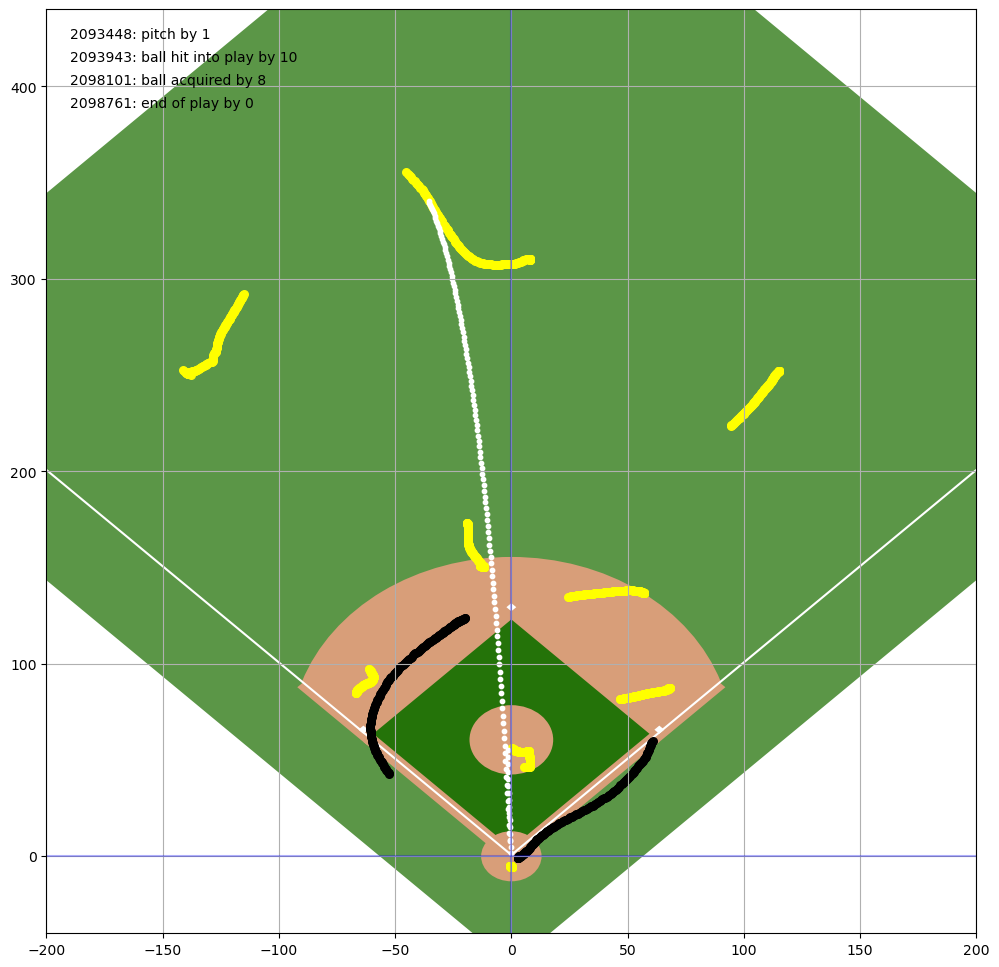

In [18]:
bf_1902_24.clear_plot()

play_id = bf_1902_24.game_obj.get_pid_from_ppg(70)

bf_1902_24.plot_all_components(play_id=play_id)
bf_1902_24.fig


# bf_1902_24.create_gif(play_id=play_id, tag="--walk off")

### Make a function to fill in game info with data from player_position

In [ ]:
bf_1902_24.game_obj.player_pos_df

In [ ]:

cols = ["play_id", "player_position_desc"]

this_play_player_pos = bf_1902_24.game_obj.new_player_pos.copy()
this_play_player_pos["player_position_desc"] = this_play_player_pos["player_position"].map(PLAYER_POSITION_CODE_TO_DESC)

which_brs_present_which_play = this_play_player_pos.loc[this_play_player_pos["player_position"].isin([10, 11, 12, 13])].groupby(cols).size().unstack(fill_value=0)
which_brs_present_which_play = which_brs_present_which_play.apply(lambda row: row.apply(lambda x: x if x == 0 else 1), axis=1)

# do the mapping between play per game and play id here
which_brs_present_which_play = which_brs_present_which_play.merge(bf_1902_24.game_obj.play_id_to_per_game_mapper, how="left", on="play_id")

In [ ]:
which_brs_present_which_play

In [ ]:
info = bf_1902_24.game_obj.game_info_df.copy()

In [ ]:
filled_info = info.merge(which_brs_present_which_play.drop("play_id", axis=1), how="left", on="play_per_game")

# I think the first thing is the 0 batter fill in, then then the br thing

filled_info["player_pos_and_info_agree"] = 1
filled_info.loc[((filled_info["first_baserunner"] > 0) ^ (filled_info["Runner 1st"] > 0)) |
                ((filled_info["second_baserunner"] > 0) ^ (filled_info["Runner 2nd"] > 0)) |
                ((filled_info["third_baserunner"] > 0) ^ (filled_info["Runner 3rd"] > 0))
                ,
                "player_pos_and_info_agree"] = 0



## ASSUMPTION: the player_pos data is generally more accurate?
## maybe just fill in a 1 where there is a 0 in game info

filled_info.loc[((filled_info["first_baserunner"] == 0) & (filled_info["Runner 1st"] > 0)), "first_baserunner"] = 1
filled_info.loc[((filled_info["second_baserunner"] == 0) & (filled_info["Runner 2nd"] > 0)), "second_baserunner"] = 1
filled_info.loc[((filled_info["third_baserunner"] == 0) & (filled_info["Runner 3rd"] > 0)), "third_baserunner"] = 1




In [ ]:
filled_info["player_pos_and_info_agree"].mean()

In [ ]:
# yikes, there are 72 instances where the first BR doesn't appear in both?

filled_info.loc[(filled_info["first_baserunner"] > 0) ^ ((filled_info["Runner 1st"] > 0))]

In [ ]:
filled_info.loc[(filled_info["second_baserunner"] > 0) ^ ((filled_info["Runner 2nd"] > 0))]

In [ ]:
filled_info.loc[(filled_info["third_baserunner"] > 0) ^ ((filled_info["Runner 3rd"] > 0))]

In [ ]:
bf_1902_24.game_obj.play_id_to_per_game_mapper.loc[bf_1902_24.game_obj.play_id_to_per_game_mapper["play_per_game"].isin(which_brs_present_which_play.index), "play_id"]

In [ ]:
which_brs_present_which_play.apply(lambda row: row.apply(lambda x: x if x == 0 else 1), axis=1)

## Test that the impute outs function works!!


In [ ]:
new_game_info_df, is_valid_dict = bf_1902_24.game_obj.impute_outs(verbose=True)

In [ ]:
new_game_info_df.tail(10)

#### Another data issue:
- there are sometimes no BR listed in the game_info, even though there is definitely a person on base
    - examples: 
        - 383 had someone get on but they aren't recorded
        - 386 shows a person on third

## Count how many times there are innings that mess up! 

In [ ]:
# get all games into a list, so I can use my Game class
all_games = {}

for sub_dir, dirs, files in os.walk('data/game_events/'):
    for file in files:
        if "checkpoint" in file:
                continue
    
        all_games[file.split("-")[-1].split(".csv")[0]] = {
            "num_valid_innings" : 0,
            "possible_half_innings" : 0
        }

# this returns 97        
print(len(all_games))     

In [ ]:
for which_game in all_games.keys():
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    
    g = bf.game_obj


    full_game = g.game_info_df.copy()

    full_game["prev_outs"] = np.nan
    full_game["this_play_outs"] = np.nan


    full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

    # you know for certain that there are no outs when it is the first batter in the half inning
    switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

    full_game.loc[switiching_sides_indices, "prev_outs"] = 0
    
    
    # make an array to store all of these
    running_outs_seq = np.full((full_game.shape[0], 2), -99)

    running_index = 0
    
    possible_half_innings = 0

    for inning in range(1, 10):
        # print(inning)

        for which_half in ["Top", "Bottom"]:

            # print(which_half)

            this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]


            if this_half.shape[0] == 0:
                print("no data for the {} of {}".format(which_half, inning))

                # TODO: this means that the home team def won in tghe inning is 9 -- maybe track this
                running_index += outs_seq.shape[0]
                continue

            outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
            # print(outs_seq.shape)

            all_games[which_game]["possible_half_innings"] += 1
            
                                  
            solve_outs_sequence_seq(g, this_half, outs_seq)

            # the total number of outs made in a half inning must be 3
            try: 
            
                assert sum(outs_seq[:, 1]) == 3
                all_games[which_game]["num_valid_innings"] += 1

            except:
                print("Assetion Error: for the {} of {}".format(which_half, inning))
                
            
            if np.isnan(outs_seq).all():
                # this means something went wrong, fill -99 so it is obvious
                outs_seq = np.full(outs_seq.shape, -99)
                
                
            # fill in this sequence into the array
            running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq

            running_index += outs_seq.shape[0]
            
            


    # assign the array back to those cols in the df
    full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


In [ ]:
coverage_of_outs_df = pd.DataFrame(all_games).T

In [ ]:
coverage_of_outs_df.describe().loc["mean", "num_valid_innings"] / coverage_of_outs_df.describe().loc["mean", "possible_half_innings"]

#### Assessment of this:
- assertion errors in the 9th are walk offs
- No data after a certain inning mean the game was rain shortened or something

- some of those that don't have 
